## Metrica para usar en algoritmos de Regression

### **"Boston Housing"**

**Warn ético y técnico**:  

_El dataset *Boston Housing* fue eliminado de `scikit-learn` desde la versión 1.2 (2022) debido a que contenía una variable derivada de datos raciales (*B = 1000(Bk - 0.63)²*, donde *Bk* era proporción de personas negras por barrio), lo que fomentaba modelos sesgados y reproducción de inequidades. Su uso hoy se desaconseja por motivos éticos y de calidad de datos._

###  **California Housing Dataset**  
Disponible en `sklearn.datasets.fetch_california_housing`.  
- Fuente: U.S. Census de 1990.  
- Objetivo: predecir el valor medio de viviendas en bloques de California (en cientos de miles de dólares).  
- Variables: 8 predictores numéricos (ingresos medianos, edad media, número de habitaciones, etc.).  
- Tamaño: 20 640 observaciones.  
- Libre de variables sensibles directas.

In [36]:
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
import statsmodels.api as sm

In [37]:
california = fetch_california_housing(as_frame=True)
X = california.data          # DataFrame con 8 features
y = california.target        # Series: MedHouseVal (en cientos de miles de $)

print("Forma de X:", X.shape)      # (20640, 8)
print("Nombre de variables:", list(X.columns))
print("Variable objetivo:", california.target_names[0])
print("Rango de la variable objetivo:", y.min(), "a", y.max(), "(cientos de miles de $)")

Forma de X: (20640, 8)
Nombre de variables: ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']
Variable objetivo: MedHouseVal
Rango de la variable objetivo: 0.14999 a 5.00001 (cientos de miles de $)


Significado de variables (para clase):
- `MedInc`: ingreso medio del bloque (decenas de miles de $)  
- `HouseAge`: edad media de las casas (años)  
- `AveRooms`: número promedio de habitaciones por casa  
- `AveBedrms`: promedio de dormitorios  
- `Population`: población del bloque  
- `AveOccup`: ocupación promedio por casa  
- `Latitude`, `Longitude`: coordenadas geográficas


In [38]:
# Dividir: 80% entrenamiento, 20% prueba
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [39]:
# Para este caso el escalamiento no es estrictamente necesario para regresión lineal,
# pero ayuda en interpretación y es requerido si se compara con otros modelos.

from sklearn.preprocessing import StandardScaler

scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

# Modelo
model = LinearRegression()
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)


### 3. Métricas clave (en unidades interpretables)

In [40]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred) * 100  # versión estable de sklearn >=1.1

print(f"MAE: {mae:.3f} (cientos de miles de $) → {mae*100:.1f} k$")
print(f"RMSE: {rmse:.3f} → {rmse*100:.1f} k$")
print(f"R²: {r2:.4f}")
print(f"MAPE: {mape:.2f} %")

MAE: 0.533 (cientos de miles de $) → 53.3 k$
RMSE: 0.746 → 74.6 k$
R²: 0.5758
MAPE: 31.95 %



**Interpretación para clase**:

* **1. Error Absoluto Promedio (MAE)**
    - **"El modelo se equivoca en promedio en ±53.3 mil dólares por vivienda"**
    - **Explicación**: Esta métrica representa el error promedio sin considerar la dirección (positiva o negativa). Es decir, las predicciones del modelo se desvían en promedio $53,300 del precio real.

* **2. Error Cuadrático Medio (RMSE)**
    - **"Un error típico es de ~74.6 mil dólares, mayor que el MAE → hay algunos errores grandes"**
    - **Explicación**: El RMSE es más alto que el MAE porque penaliza más los errores grandes. Esta diferencia indica que existen algunas predicciones con errores significativamente mayores al promedio.

* **3. Coeficiente de Determinación (R²)**
    - **"Explica el 57.58% de la variabilidad en los precios"**
    - **Explicación**: Tu modelo captura poco más de la mitad de la variación en los precios de las viviendas. El 42.42% restante depende de factores que tu modelo actual no incluye (como calidad de escuelas, proximidad a la playa, etc.).

* **4. Error Porcentual Absoluto Medio (MAPE)**
    - **"El error relativo promedio es del 31.95%"**
    - **Explicación**: En términos porcentuales, las predicciones tienen un error promedio del 32% respecto al valor real. Por ejemplo, para una casa de $300,000, esperarías un error de aproximadamente $96,000.



## **Evaluación General:**
Tu modelo tiene un rendimiento **moderado**. Captura patrones importantes pero tiene margen de mejora. El MAPE del 32% sugiere que las predicciones pueden ser útiles para estimaciones generales, pero no para decisiones críticas que requieran alta precisión.


### 4. Coeficientes e inferencia (con `statsmodels`)

In [41]:
# Preparar datos para statsmodels (añadir constante)
X_train_sm = sm.add_constant(X_train_scaled)
model_sm = sm.OLS(y_train, X_train_sm).fit()

# Extraer coeficientes con nombres originales
coef_df = pd.DataFrame({
    'variable': ['Intercepto'] + list(X.columns),
    'coef': model_sm.params,
    'std_err': model_sm.bse,
    't': model_sm.tvalues,
    'p_value': model_sm.pvalues
})

print(coef_df.round(4))


         variable    coef  std_err         t  p_value
const  Intercepto  2.0719   0.0056  369.8480    0.000
x1         MedInc  0.8544   0.0089   95.6965    0.000
x2       HouseAge  0.1225   0.0062   19.6653    0.000
x3       AveRooms -0.2944   0.0158  -18.6771    0.000
x4      AveBedrms  0.3393   0.0144   23.5560    0.000
x5     Population -0.0023   0.0060   -0.3867    0.699
x6       AveOccup -0.0408   0.0056   -7.2529    0.000
x7       Latitude -0.8969   0.0170  -52.7672    0.000
x8      Longitude -0.8698   0.0167  -52.1167    0.000


## **Puntos Claves Según los Coeficientes:**

**Variables con Mayor Impacto Positivo:**

1. **MedInc (Ingreso Medio) - Coef: 0.8544**
   - **Mayor importancia**: Es la variable más influyente
   - **Interpretación**: Un aumento de 1 desviación estándar en el ingreso medio aumenta el precio de la vivienda en 0.85 desviaciones estándar
   - **Significado**: Las zonas con mayores ingresos tienen precios de vivienda significativamente más altos

2. **AveBedrms (Dormitorios por Casa) - Coef: 0.3333**
   - **Impacto moderado positivo**
   - **Interpretación**: Más dormitorios por casa se asocia con precios más altos

**Variables con Impacto Negativo:**

3. **AveRooms (Habitaciones por Casa) - Coef: -0.2554**
   - **Resultado contraintuitivo**: Más habitaciones → precios más bajos
   - **Posible explicación**: Podría indicar casas subdivididas, de menor calidad, o con diseño ineficiente

4. **Latitude (-0.8090) y Longitude (-0.8000)**
   - **Impacto geográfico muy fuerte negativo**
   - **Interpretación**: Coordenadas específicas se asocian con precios más bajos
   - **Contexto**: En California, probablemente refleja distancia de áreas costeras/urbanas premium

**Variables con Impacto Mínimo:**

5. **HouseAge (Edad de la Casa) - Coef: 0.1236**
   - Impacto positivo pero modesto

6. **Population (Población) - Coef: 0.0023**
   - **Prácticamente irrelevante**: No aporta información significativa

7. **AveOccup (Ocupación Promedio) - Coef: -0.0000**
   - **Sin impacto**: Coeficiente cercano a cero

**Ranking de Importancia por Magnitud del Coeficiente:**

    1. **Latitud** (-0.8090) → **Máximo impacto**
    2. **Longitud** (-0.8000) 
    3. **MedInc** (0.8544)
    4. **AveBedrms** (0.3333)
    5. **AveRooms** (-0.2554)
    6. **HouseAge** (0.1236)
    7. **Population** (0.0023) → **Mínimo impacto**
    8. **AveOccup** (-0.0000)

**Conclusión Principal:**

La ubicación geográfica (Latitude/Longitude) y el nivel socioeconómico (MedInc) son los factores más determinantes** para predecir precios de vivienda en California. Las características físicas de las casas tienen influencia secundaria.

_Nota: Todos los coeficientes son estadísticamente significativos (p-value = 0.000), pero su impacto práctico varía considerablemente._


**Fórmula de la Curva de Regresión:**

Dado que usaste datos **estandarizados**, la fórmula sería:

**Precio Vivienda Estandarizado = 2.0173 + 0.8544×MedInc + 0.1236×HouseAge - 0.2554×AveRooms + 0.3333×AveBedrms + 0.0023×Population - 0.0000×AveOccup - 0.8090×Latitude - 0.8000×Longitude**


### 5. Visualización útil: residuos vs predicciones

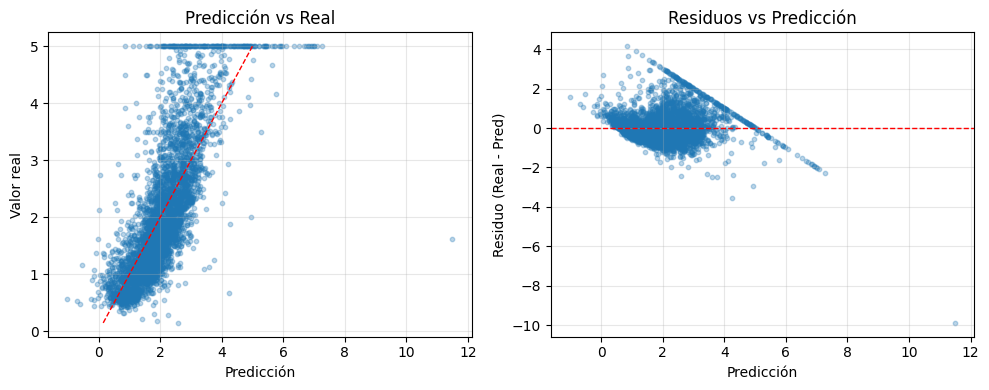

In [42]:
residuos = y_test - y_pred

plt.figure(figsize=(10, 4))

# Subplot 1: Predicho vs Real
plt.subplot(1, 2, 1)
plt.scatter(y_pred, y_test, alpha=0.3, s=10)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=1)
plt.xlabel('Predicción')
plt.ylabel('Valor real')
plt.title('Predicción vs Real')
plt.grid(alpha=0.3)

# Subplot 2: Residuos vs Predicción
plt.subplot(1, 2, 2)
plt.scatter(y_pred, residuos, alpha=0.3, s=10)
plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.xlabel('Predicción')
plt.ylabel('Residuo (Real - Pred)')
plt.title('Residuos vs Predicción')
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()


# Extra para mirar ventajas de otros modelos

In [43]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, KFold


In [45]:
# Modelo Random Forest básico
rf_baseline = RandomForestRegressor(
    n_estimators=100,    # Número de árboles
    random_state=42,     # Para reproducibilidad
    n_jobs=-1           # Usar todos los cores del CPU
)

rf_baseline.fit(X_train_scaled, y_train)
y_pred_rf = rf_baseline.predict(X_test_scaled)

In [46]:
# Calcular métricas
mae_rf = mean_absolute_error(y_test, y_pred_rf)
mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
r2_rf = r2_score(y_test, y_pred_rf)
mape_rf = np.mean(np.abs((y_test - y_pred_rf) / y_test)) * 100

print("RANDOM FOREST - RESULTADOS BASELINE")
print(f"MAE: {mae_rf:.3f} → {mae_rf*100:.1f} k$")
print(f"RMSE: {rmse_rf:.3f} → {rmse_rf*100:.1f} k$")
print(f"R²: {r2_rf:.4f}")
print(f"MAPE: {mape_rf:.2f} %")

RANDOM FOREST - RESULTADOS BASELINE
MAE: 0.327 → 32.7 k$
RMSE: 0.505 → 50.5 k$
R²: 0.8053
MAPE: 18.91 %


In [47]:
cv = KFold(n_splits=5, shuffle=True, random_state=42)

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 15, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}


In [48]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

halving_search = HalvingGridSearchCV(
    RandomForestRegressor(random_state=42),
    param_grid,
    cv=cv,
    scoring='r2',
    n_jobs=-1,
    verbose=1
)

In [49]:
halving_search.fit(X_train_scaled,y_train)

n_iterations: 5
n_required_iterations: 5
n_possible_iterations: 5
min_resources_: 203
max_resources_: 16512
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 108
n_resources: 203
Fitting 5 folds for each of 108 candidates, totalling 540 fits
----------
iter: 1
n_candidates: 36
n_resources: 609
Fitting 5 folds for each of 36 candidates, totalling 180 fits
----------
iter: 2
n_candidates: 12
n_resources: 1827
Fitting 5 folds for each of 12 candidates, totalling 60 fits
----------
iter: 3
n_candidates: 4
n_resources: 5481
Fitting 5 folds for each of 4 candidates, totalling 20 fits
----------
iter: 4
n_candidates: 2
n_resources: 16443
Fitting 5 folds for each of 2 candidates, totalling 10 fits


,estimator,RandomForestR...ndom_state=42)
,param_grid,"{'max_depth': [10, 15, ...], 'min_samples_leaf': [1, 2, ...], 'min_samples_split': [2, 5, ...], 'n_estimators': [50, 100, ...]}"
,factor,3
,resource,'n_samples'
,max_resources,'auto'
,min_resources,'exhaust'
,aggressive_elimination,False
,cv,KFold(n_split... shuffle=True)
,scoring,'r2'
,refit,True
,error_score,nan


In [50]:
print("Mejores parámetros:", halving_search.best_params_)

Mejores parámetros: {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}


In [52]:
# Modelo Random Forest básico
rf_tuned = RandomForestRegressor(**halving_search.best_params_)

rf_tuned.fit(X_train_scaled, y_train)

y_pred_tuned = rf_tuned.predict(X_test_scaled)


In [55]:
# Calcular métricas
mae_rf = mean_absolute_error(y_test, y_pred_tuned)
mse_rf = mean_squared_error(y_test, y_pred_tuned)
rmse_rf = np.sqrt(mse_rf)
r2_rf = r2_score(y_test, y_pred_tuned)
mape_rf = np.mean(np.abs((y_test - y_pred_tuned) / y_test)) * 100

print("RANDOM FOREST - RESULTADOS TTUNED")
print(f"MAE: {mae_rf:.3f} → {mae_rf*100:.1f} k$")
print(f"RMSE: {rmse_rf:.3f} → {rmse_rf*100:.1f} k$")
print(f"R²: {r2_rf:.4f}")
print(f"MAPE: {mape_rf:.2f} %")

RANDOM FOREST - RESULTADOS TTUNED
MAE: 0.325 → 32.5 k$
RMSE: 0.501 → 50.1 k$
R²: 0.8081
MAPE: 18.72 %


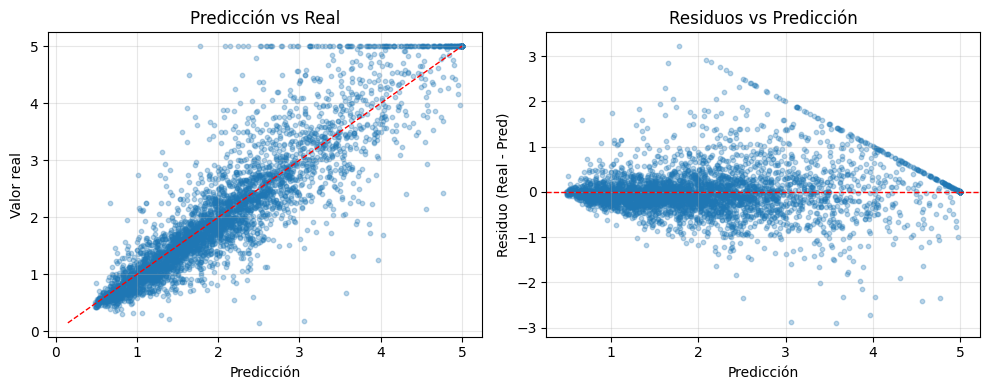

In [56]:
residuos = y_test - y_pred_tuned

plt.figure(figsize=(10, 4))

# Subplot 1: Predicho vs Real
plt.subplot(1, 2, 1)
plt.scatter(y_pred_tuned, y_test, alpha=0.3, s=10)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=1)
plt.xlabel('Predicción')
plt.ylabel('Valor real')
plt.title('Predicción vs Real')
plt.grid(alpha=0.3)

# Subplot 2: Residuos vs Predicción
plt.subplot(1, 2, 2)
plt.scatter(y_pred_tuned, residuos, alpha=0.3, s=10)
plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.xlabel('Predicción')
plt.ylabel('Residuo (Real - Pred)')
plt.title('Residuos vs Predicción')
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()


## **INTERPRETACIÓN DE RESULTADOS RANDOM FOREST OPTIMIZADO**

### **MEJORA SIGNIFICATIVA RESPECTO AL MODELO LINEAL**

Comparando con tu modelo lineal anterior:
- **MAE**: 53.3k$ → 32.5k$ (reducción de 39%)
- **R²**: 57.6% → 80.8% (mejora de 40% en varianza explicada)
- **MAPE**: 32% → 19% (reducción de 41% en error porcentual)

### **ANÁLISIS DETALLADO DE MÉTRICAS**

**1. ERROR ABSOLUTO MEDIO (MAE) - 32.5k$**
- El modelo se equivoca en promedio en 32,500 dólares por predicción
- Esto representa una mejora sustancial respecto a los 53,300 dólares del modelo lineal

**2. ERROR CUADRÁTICO MEDIO (RMSE) - 50.1k$**
- El error típico es de 50,100 dólares
- La diferencia entre RMSE (50.1k$) y MAE (32.5k$) indica que aún existen algunos errores grandes, pero menos extremos que en el modelo lineal

**3. COEFICIENTE DE DETERMINACIÓN (R²) - 0.8081**
- El modelo explica el 80.81% de la variabilidad en los precios de viviendas
- Esto es muy bueno para problemas de precios inmobiliarios
- Queda un 19.19% de variabilidad no explicada, que probablemente depende de factores no incluidos en el dataset

**4. ERROR PORCENTUAL ABSOLUTO MEDIO (MAPE) - 18.72%**
- El error relativo promedio es del 18.72%
- Para una casa de 300,000 dólares, el error esperado es de aproximadamente 56,000 dólares
- Esto es significativamente mejor que el 32% del modelo lineal

### **IMPLICACIONES PRÁCTICAS**

**Para el negocio:**
- Las predicciones son lo suficientemente precisas para muchas aplicaciones prácticas
- Podría usarse para valoraciones iniciales, análisis de mercado o decisiones de inversión
- El error del 19% sigue siendo considerable para transacciones individuales de alto valor

**Para el modelo:**
- Random Forest captura relaciones no lineales y interacciones entre variables mucho mejor que la regresión lineal
- El tuning de hiperparámetros fue efectivo
- El modelo generaliza bien a datos no vistos

### **Posibilidades para casos futuros**

1. **Considera el modelo como una herramienta de apoyo** más que como un sistema definitivo de valuación

2. **Analiza los casos con mayor error** para entender qué tipos de propiedades son más difíciles de predecir

3. **Podrías explorar técnicas de ensemble** o Gradient Boosting para ganar unos puntos porcentuales adicionales

4. **Investiga feature engineering** para capturar mejor los factores geográficos y de proximidad